# Continuous Control with Deep Deterministic Policy Gradients

---

In this notebook I will train an agent to control a jointed arm, to move it to a desired target location. The algorithm that I will be using is called [Deep Deterministic Policy Gradients](https://arxiv.org/pdf/1509.02971.pdf). This is a sort of actor-critic algorithm, where the actor network learns a policy that relates actions to states, and the critic network learns a value function that gives a Q-value to state-action pairs.

### 0. Import the Necessary Packages

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

### 1. Start the Environment

In [3]:
# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Train the agent using DDPG while acting in the environment

In [6]:
agent = Agent(num_agents, state_size, action_size, random_seed=2)

Episode 100	Average Score: 3.96
Episode 200	Average Score: 13.81
Episode 300	Average Score: 19.25
Episode 376	Average Score: 30.09
Environment solved in 276 episodes!	Average Score: 30.09


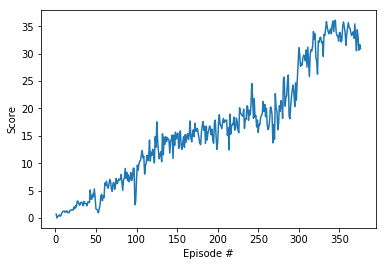

In [7]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every) # last 100 scores
    avg_scores = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment at episode start
        states = env_info.vector_observations                      # get the initial state (for each agent)
        agent.reset()                                              # reset the agent
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)
        t = 0                                                      # variable to keep track of time step
        
        while(True):
            t += 1
            actions = agent.act(states)                            # agent provides an action for this state
            
            env_info = env.step(actions)[brain_name]               # step in environment using action
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            scores += rewards                                      # update the score (for each agent)
            agent.step(t, states, actions, rewards, next_states, dones) # perform a step in the agent
            states = next_states                                   # roll over state to next time step
            
            if np.any(dones):
                break
                
        scores_deque.append(np.mean(scores))                       # save most recent average score
        avg_scores.append(np.mean(scores)) 
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return avg_scores

avg_scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
# Close the environment
env.close()